In [68]:
from dotenv import load_dotenv
import os
from langsmith import traceable

# Cargar el archivo .env
load_dotenv('../.env')

True

In [3]:
import os
from typing import Dict, Any, List, Optional
from pydantic import BaseModel
from typing_extensions import TypedDict, Annotated

from langchain_core.language_models import BaseChatModel
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, BaseMessage
from typing import Any as _Any
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from langchain_core.runnables import RunnablePassthrough
import logging

/home/igorov/dev/miniconda3/envs/v310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Qdrant

In [4]:
import os
from qdrant_client import QdrantClient
from langchain_qdrant import QdrantVectorStore

qdrant_url = os.getenv('QDRANT_URL')
qdrant_key = os.getenv('QDRANT_KEY')
collection_name = os.getenv('QDRANT_COLLECTION_NAME')

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

print(f"[Qdrant] URL: {qdrant_url} | Collection: {collection_name}")
client = QdrantClient(
    url=qdrant_url,
    api_key=qdrant_key
)

qdrant_store = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=embeddings
)

retriever = qdrant_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 10}
)

message_history_limit = 10

[Qdrant] URL: https://5d3a3746-9bf9-4feb-8c37-3e0fecba6e25.us-east4-0.gcp.cloud.qdrant.io | Collection: techFlow-academy


# Conexion con BD

In [69]:
from psycopg_pool import ConnectionPool

def init_pool(dsn: Optional[str] = None, min_size: int = 1, max_size: int = 10) -> ConnectionPool:
    effective_dsn = dsn or os.getenv("POSTGRES_URL") or os.getenv("DATABASE_URL")
    if not effective_dsn:
        raise ValueError("POSTGRES_URL o DATABASE_URL no está configurado en el entorno")

    _pool = ConnectionPool(effective_dsn, min_size=min_size, max_size=max_size)
    return _pool


pool = init_pool()

# Grafo

## Modelo

In [39]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

## Tools

In [82]:
import os
from google.oauth2.service_account import Credentials
from google.auth import default
from googleapiclient.discovery import build
from datetime import datetime
from typing import Optional

GOOGLE_SHEETS_SPREADSHEET_ID = os.getenv("GOOGLE_SHEETS_SPREADSHEET_ID")
GOOGLE_SHEETS_NAME = os.getenv("GOOGLE_SHEETS_NAME")
GOOGLE_CREDENTIALS_FILE = os.getenv("GOOGLE_CREDENTIALS_FILE")

def registrar_cliente(email: str, nombres: str, apellidos: str, numero_documento: str, telefono: str):
    """
    Registra una nueva fila en Google Sheets

    Args:
        email: Correo electrónico del usuario
        nombres: Nombre del usuario
        apellidos: Apellido del usuario
        numero_documento: Número de documento
        telefono: Número de teléfono

    Returns:
        str: 'ok' si la operación fue exitosa
    """
    try:
        # Configuración de credenciales
        credentials_file = GOOGLE_CREDENTIALS_FILE
        spreadsheet_id = GOOGLE_SHEETS_SPREADSHEET_ID
        sheet_name = GOOGLE_SHEETS_NAME

        # Scopes necesarios
        scopes = [
            'https://www.googleapis.com/auth/spreadsheets',
            'https://www.googleapis.com/auth/drive.file'
        ]

        # Autenticación
        if credentials_file and os.path.exists(credentials_file):
            # Local: usar archivo JSON
            credentials = Credentials.from_service_account_file(credentials_file, scopes=scopes)
            print("Usando archivo JSON local")
        else:
            # Cloud Run: usar Application Default Credentials
            credentials, _ = default(scopes=scopes)
            
        print("Usando Application Default Credentials")
        #credentials = Credentials.from_service_account_file(scopes=scopes)
        service = build('sheets', 'v4', credentials=credentials)

        fecha_registro = datetime.now().strftime('%d/%m/%Y %H:%M:%S')

        # Preparar los datos de la nueva fila
        new_row = [
            fecha_registro,
            email,
            nombres,
            apellidos,
            numero_documento,
            telefono
        ]

        # Rango donde agregar la nueva fila
        range_to_append = f"{sheet_name}!A:F"

        # Cuerpo de la petición
        body = {
            'values': [new_row]
        }

        # Encontrar la próxima fila vacía para evitar copiar formato
        # Primero obtenemos los datos existentes para saber cuántas filas hay
        existing_data = service.spreadsheets().values().get(
            spreadsheetId=spreadsheet_id,
            range=f"{sheet_name}!A:A"
        ).execute()

        # Calcular la próxima fila vacía
        existing_rows = len(existing_data.get('values', []))
        next_row = existing_rows + 1

        # Insertar en la fila específica (esto evita copiar formato)
        specific_range = f"{sheet_name}!A{next_row}:F{next_row}"

        result = service.spreadsheets().values().update(
            spreadsheetId=spreadsheet_id,
            range=specific_range,
            valueInputOption='RAW',
            body=body
        ).execute()

        rows_added = result.get("updates", {}).get("updatedRows", 0)
        print(f'Usuario registrado correctamente')
        print(f'Fecha de registro: {fecha_registro}')

        return 'ok'

    except Exception as error:
        print(f'Error al registrar el usuario: {error}')
        raise error

def contar_registros():
    """
    Cuenta cuántos registros (filas) hay en el Google Sheet

    Returns:
        str: Mensaje con el número de registros
    """
    include_headers = False

    # Configuración de credenciales
    credentials_file = GOOGLE_CREDENTIALS_FILE
    spreadsheet_id = GOOGLE_SHEETS_SPREADSHEET_ID
    sheet_name = GOOGLE_SHEETS_NAME
    
    try:
        # Scopes necesarios para Google Sheets
        scopes = [
            'https://www.googleapis.com/auth/spreadsheets',
            'https://www.googleapis.com/auth/drive.file'
        ]

        # Autenticación
        if credentials_file and os.path.exists(credentials_file):
            # Local: usar archivo JSON
            credentials = Credentials.from_service_account_file(credentials_file, scopes=scopes)
            print("Usando archivo JSON local")
        else:
            # Cloud Run: usar Application Default Credentials
            credentials, _ = default(scopes=scopes)

        # Crear el servicio de Google Sheets
        service = build('sheets', 'v4', credentials=credentials)

        # Obtener todas las filas con datos (columna A como referencia)
        result = service.spreadsheets().values().get(
            spreadsheetId=GOOGLE_SHEETS_SPREADSHEET_ID,
            range=f"{GOOGLE_SHEETS_NAME}!A:A"
        ).execute()

        # Contar filas con datos
        rows_with_data = result.get('values', [])
        total_rows = len(rows_with_data)

        if include_headers:
            registros = total_rows
            print(f'Total de filas (incluyendo headers): {registros}')
        else:
            # Restar 1 para excluir la fila de headers
            registros = max(0, total_rows - 1)
            print(f'Total de registros (sin headers): {registros}')
            print(f'Total de filas (con headers): {total_rows}')

        return f"Hay {registros} clientes registrados"

    except Exception as error:
        print(f'Error al contar registros: {error}')
        raise error

def get_current_date() -> dict:
    """
    Obtener la fecha actual en el formato YYYY-MM-DD
    """
    return {"current_date": datetime.now().strftime("%Y-%m-%d")}

def get_program_price(program_name: str) -> dict:
    """Obtiene el precio de un programa mediante su nombre.

    Parameters
    ----------
    program_name: str
        Nombre del programa a buscar.

    Returns
    -------
    dict
        {"program_price": float | None}
    """
    if not isinstance(program_name, str) or not program_name.strip():
        return {"program_price": None}
    
    print(f"Buscando precio del programa: {program_name}")

    query = (
        """
        SELECT precio
        FROM public.programas
        WHERE nombre ILIKE '%%' || %s || '%%'
        ORDER BY CASE WHEN lower(nombre) = lower(%s) THEN 0 ELSE 1 END, nombre
        LIMIT 1
        """
    )

    try:
        with pool.connection() as connection:
            with connection.cursor() as cursor:
                cursor.execute(query, (program_name, program_name))
                row: Optional[tuple] = cursor.fetchone()
                if not row:
                    return {"program_price": None}
                price_value = row[0]
                try:
                    # Asegurar retorno numérico float
                    price_float = float(price_value) if price_value is not None else None
                except Exception:
                    price_float = None
                return {"program_price": price_float}
    except Exception as exc:
        # Log simple; en entornos reales usar logger
        print(f"[get_program_price] Error consultando precio: {exc}")
        return {"program_price": None}

## Model con tools

In [11]:
model = llm.bind_tools([
    registrar_cliente,
    contar_registros,
    get_current_date,
    get_program_price,
])

## Estado

In [44]:
class AdaptiveAgentState(TypedDict):
    """
    Estado personalizado que incluye mensajes y metadatos del RAG adaptativo
    """
    messages: Annotated[List[BaseMessage], add_messages]
    complexity_level: Optional[str]
    retrieved_docs: Optional[List[Any]]
    question: Optional[str]  # Pregunta actual (original o reformulada)
    generation: Optional[str]  # Respuesta generada
    answer_evaluation: Optional[str]  # Resultado de evaluación de la respuesta ('yes'/'no')
    max_retries: Optional[int]  # Máximo número de reintentos
    retry_count: Optional[int]  # Contador de reintentos
    rag_processs: Optional[str]  # Proceso de RAG ('rag'/'no_rag')

## Prompts

In [15]:
COMPLEXITY_PROMPT = """Eres un experto clasificando la complejidad de preguntas de estudiantes de TechFlow Academy.

Clasifica la pregunta en uno de estos 3 niveles:

SIMPLE: Saludos, consultas básicas sobre horarios, ubicación, contacto, despedidas
- Ejemplos: "Hola", "¿Están abiertos?", "¿Dónde quedan?", "Gracias", "Adiós"

RAG: Preguntas sobre programas, cursos, profesores, metodología, contenido académico
- Ejemplos: "¿Qué incluye Data Engineering?", "¿Quién enseña ML?", "¿Cómo son las clases?"

TOOLS: Preguntas sobre costos, inscripciones, disponibilidad de cupos, registro
- Ejemplos: "¿Cuánto cuesta?", "¿Hay cupos en Data Science?", "Quiero inscribirme"

Retorna JSON con clave 'complexity_level' y valor 'simple', 'rag' o 'tools'.

Pregunta: {question}"""

TOOL_ROUTER_PROMPT = """Eres un router que determina qué herramienta usar según la pregunta del estudiante.

Herramientas disponibles:
- get_course_cost: Para preguntas sobre precios, costos, valores de programas
- get_student_count: Para preguntas sobre cuántos estudiantes, disponibilidad, cupos
- register_student: Para inscripciones, registros, matriculas

Ejemplos:
"¿Cuánto cuesta Data Engineering?" → get_course_cost
"¿Hay cupos disponibles?" → get_student_count  
"Quiero inscribirme en ML Engineer" → register_student

Retorna JSON con clave 'tool_name' y el nombre de la herramienta.

Pregunta: {question}"""

SIMPLE_PROMPT = """Eres un asistente amigable de TechFlow Academy, un instituto de programación y ciencia de datos en Lima, Perú.

Para consultas simples como saludos, ubicación, horarios básicos, contacto:
- Responde de forma cordial y directa
- Menciona que TechFlow Academy es especialista en Data Engineering, ML Engineering, Data Visualization, etc.
- Para consultas específicas sobre programas, costos o inscripciones, indica que puedes ayudar con información detallada
- Mantén un tono profesional pero cercano

Información básica:
- Horarios: Lunes a viernes 7AM-10PM, Sábados 8AM-8PM
- Sedes: Miraflores, San Isidro, La Molina, Surco
- Modalidades: Virtual, Presencial, Híbrida
- WhatsApp: Canal principal de comunicación"""

RAG_PROMPT = """Eres un asistente especializado de TechFlow Academy. 

Responde la pregunta basándote únicamente en el contexto proporcionado sobre nuestros programas, profesores, metodología y servicios.

Instrucciones:
- Usa solo la información del contexto
- Si no encuentras información específica, indica que puedes ayudar de otra manera
- Mantén respuestas claras y estructuradas
- Incluye detalles relevantes como duración, modalidades, requisitos
- Sugiere próximos pasos cuando sea apropiado (ej: "¿Te gustaría conocer los costos?")"""

TOOL_PROMPT = """Eres un asistente de TechFlow Academy especializado en información sobre costos, inscripciones y disponibilidad.

Genera una respuesta natural y útil basada en el resultado de la herramienta consultada.

Instrucciones:
- Presenta la información de forma clara y estructurada
- Incluye próximos pasos o acciones recomendadas
- Mantén tono profesional pero amigable
- Si es información de costos, menciona opciones de financiamiento
- Si es sobre disponibilidad, sugiere alternativas si es necesario
- Si es registro, confirma y explica siguientes pasos"""

MODEL_SYSTEM_MESSAGE = """Eres un asistente especializado de TechFlow Academy, un instituto de programación y ciencia de datos en Lima, Perú.

Tu función es ayudar a estudiantes potenciales y actuales con información sobre programas, inscripciones y servicios.

Instrucciones:
- Mantén respuestas claras y profesionales
- Usa las herramientas disponibles cuando sea necesario para obtener información actualizada
- Si necesitas registrar un estudiante, asegúrate de obtener todos los datos requeridos
- Para consultas sobre costos o cupos, usa las herramientas correspondientes
- Proporciona información útil y sugiere próximos pasos cuando sea apropiado

Herramientas disponibles:
- registrar_cliente: Para registrar información de estudiantes interesados
- contar_registros: Para consultar cuántos estudiantes están registrados
- get_current_date: Para obtener la fecha actual

Información básica de TechFlow Academy:
- Horarios: Lunes a viernes 7AM-10PM, Sábados 8AM-8PM
- Sedes: Miraflores, San Isidro, La Molina, Surco
- Modalidades: Virtual, Presencial, Híbrida
- Programas: Data Engineering, ML Engineering, Data Visualization, Data Science"""

# Prompts para RAG Adaptativo

GRADE_DOCUMENTS_PROMPT = """Eres un evaluador que determina si los documentos recuperados son relevantes para responder la pregunta del estudiante.

Evalúa cada documento y determina si contiene información útil para responder la pregunta.

Documentos relevantes son aquellos que:
- Contienen información directamente relacionada con la pregunta
- Proporcionan contexto útil para formular una respuesta completa
- Incluyen detalles específicos sobre programas, profesores, metodología, etc.

Documentos NO relevantes son aquellos que:
- No tienen relación con la pregunta
- Contienen información genérica sin valor específico
- No aportan contexto útil para la respuesta

Pregunta: {question}

Documentos a evaluar: {documents}

Responde con 'yes' si al menos uno de los documentos es relevante, o 'no' si ninguno es relevante."""

EVALUATE_ANSWER_PROMPT = """Eres un evaluador que determina si una respuesta generada responde adecuadamente la pregunta del estudiante.

Evalúa si la respuesta:
- Responde directamente la pregunta formulada
- Proporciona información específica y útil
- Está basada en el contexto proporcionado
- No contiene información inventada o alucinada
- Es clara y comprensible

Pregunta: {question}

Respuesta generada: {generation}

Documentos de contexto: {documents}

Responde con 'yes' si la respuesta es adecuada, o 'no' si necesita mejoras."""

REWRITE_QUESTION_PROMPT = """Eres un experto en reformular preguntas para mejorar la recuperación de documentos relevantes.

La pregunta original no obtuvo documentos relevantes. Reescribe la pregunta para:
- Usar términos más específicos relacionados con programación y ciencia de datos
- Incluir sinónimos o términos alternativos
- Hacer la pregunta más clara y específica
- Mantener la intención original pero con mejor búsqueda

Pregunta original: {question}

Genera una pregunta reformulada que mejore la recuperación de documentos relevantes."""

WEB_SEARCH_PROMPT = """La información en nuestra base de conocimientos no fue suficiente para responder esta pregunta sobre TechFlow Academy.

Genera una respuesta útil reconociendo las limitaciones y sugiriendo próximos pasos:

- Indica que la información específica no está disponible en este momento
- Sugiere contactar directamente para información más detallada
- Proporciona información general que sí conoces sobre TechFlow Academy
- Mantén un tono profesional y servicial

Pregunta: {question}

Contexto disponible: {documents}"""

## Nodos

In [16]:
class DocumentRelevance(BaseModel):
    """Modelo para evaluación de relevancia de documentos"""
    decision: str  # 'yes' o 'no'

class ComplexityLevel(BaseModel):
    """Modelo para clasificación de complejidad"""
    complexity_level: str

class AnswerEvaluation(BaseModel):
    """Modelo para evaluación de calidad de respuesta"""
    decision: str  # 'yes' o 'no'

class QuestionRewrite(BaseModel):
    """Modelo para re-escritura de preguntas"""
    rewritten_question: str

In [17]:
def get_last_messages(state: "AdaptiveAgentState", limit: Optional[int] = None) -> List[BaseMessage]:
    effective_limit = limit if isinstance(limit, int) and limit > 0 else message_history_limit
    messages = state.get("messages", [])
    if not messages:
        return []
    if len(messages) <= effective_limit:
        return messages
    return messages[-effective_limit:]

def format_docs(docs):
        """Format documents for RAG context"""
        return "\n\n".join(doc.page_content for doc in docs)

#@traceable(name="classify_complexity")
def classify_complexity(state: AdaptiveAgentState):
    """Classify question complexity based on last human message"""
    print("---CLASSIFY COMPLEXITY---")
    
    complexity_prompt = PromptTemplate(template=COMPLEXITY_PROMPT, input_variables=["question"])
    complexity_classifier = (
        complexity_prompt 
        | llm.with_structured_output(ComplexityLevel)
    )
    
    # Extraer la última pregunta del usuario de los mensajes
    last_human_message = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            last_human_message = msg.content
            break
    
    if not last_human_message:
        # Si no hay mensaje humano, usar mensaje por defecto
        complexity_level = "simple"
    else:
        result = complexity_classifier.invoke({"question": last_human_message})
        complexity_level = result.complexity_level
    
    print(f"Complexity Level: {complexity_level}")
    # Retornar el estado actualizado con el nivel de complejidad
    return {
        "complexity_level": complexity_level,
        "retrieved_docs": state.get("retrieved_docs", None)
    }

#@traceable(name="simple_response") 
def simple_response(state: AdaptiveAgentState):
    """Generate simple response using full chat history"""
    print("---SIMPLE RESPONSE---")

    # Prepend a system message and pass the full history to the chat model
    messages_for_model: List[BaseMessage] = [
        SystemMessage(content=SIMPLE_PROMPT)
    ] + get_last_messages(state)

    response = llm.invoke(messages_for_model)
    return {"messages": [response]}

#@traceable(name="rag_retrieve")
def rag_retrieve(state: AdaptiveAgentState):
    """Retrieve documents for RAG"""
    print("---RAG RETRIEVE---")
    
    # Obtener la pregunta (original o reformulada)
    question = state.get("question")
    if not question:
        # Extraer la última pregunta del usuario
        for msg in reversed(state["messages"]):
            if isinstance(msg, HumanMessage):
                question = msg.content
                break
    
    if not question:
        question = "información general"
    
    # Recuperar documentos
    print(f"Recuperando contexto de pregunta: {question}")
    documents = retriever.get_relevant_documents(question)

    print(f"[RAG] Docs recuperados: {len(documents)}")
    for i, doc in enumerate(documents):
        preview = doc.page_content.replace('\n',' ')[:220]
        print(f"[{i}] {preview}")
        print(f"    meta: {doc.metadata}")

    # Retornar estado actualizado con documentos y pregunta
    return {
        "retrieved_docs": documents,
        "question": question,
        "max_retries": state.get("max_retries", 3),
        "retry_count": state.get("retry_count", 0)
    }

def grade_documents(state: AdaptiveAgentState):
    grade_docs_prompt = PromptTemplate(template=GRADE_DOCUMENTS_PROMPT, input_variables=["question", "documents"])
    document_grader = (
        grade_docs_prompt 
        | llm.with_structured_output(DocumentRelevance)
    )

    """Grade document relevance to question"""
    print("---GRADE DOCUMENTS---")
    
    question = state.get("question", "")
    documents = state.get("retrieved_docs", [])
    
    if not documents:
        print("No documents to grade")
        return {"retrieved_docs": []}
    
    # Formatear documentos para evaluación
    docs_text = format_docs(documents)
    
    # Evaluar relevancia
    result = document_grader.invoke({"question": question, "documents": docs_text})
    print(f"Document relevance: {result.decision}")
    
    if result.decision == "yes":
        print("Documents are relevant")
        return {"retrieved_docs": documents}
    else:
        print("Documents are not relevant")
        return {"retrieved_docs": []}

def rag_generate(state: AdaptiveAgentState):
    """Generate RAG response using full chat history + context"""
    print("---RAG GENERATE---")

    # Obtener documentos recuperados
    documents = state.get("retrieved_docs", [])
    context_text = format_docs(documents) if documents else ""

    # Prepend system with instructions and context, then pass full history
    system_content = f"{RAG_PROMPT}\n\nContexto:\n{context_text}"
    messages_for_model: List[BaseMessage] = [
        SystemMessage(content=system_content)
    ] + get_last_messages(state)

    response = llm.invoke(messages_for_model)
    
    # Almacenar la respuesta generada para evaluación
    return {
        "messages": [response],
        "generation": response.content
    }

def evaluate_answer(state: AdaptiveAgentState):
    """Evaluate if the generated answer is adequate"""
    print("---EVALUATE ANSWER---")

    evaluate_answer_prompt = PromptTemplate(template=EVALUATE_ANSWER_PROMPT, input_variables=["question", "generation", "documents"])
    answer_evaluator = (
        evaluate_answer_prompt 
        | llm.with_structured_output(AnswerEvaluation)
    )
    
    question = state.get("question", "")
    generation = state.get("generation", "")
    documents = state.get("retrieved_docs", [])
    docs_text = format_docs(documents) if documents else ""
    
    # Evaluar la respuesta
    result = answer_evaluator.invoke({
        "question": question,
        "generation": generation,
        "documents": docs_text
    })
    
    print(f"Answer evaluation: {result.decision}")
    return {
        "generation": generation,
        "answer_evaluation": result.decision  # Almacenar el resultado de la evaluación
    }

def rewrite_question(state: AdaptiveAgentState):
    """Rewrite question to improve retrieval"""
    print("---REWRITE QUESTION---")

    rewrite_question_prompt = PromptTemplate(template=REWRITE_QUESTION_PROMPT, input_variables=["question"])
    question_rewriter = (
        rewrite_question_prompt 
        | llm.with_structured_output(QuestionRewrite)
    )
    
    original_question = state.get("question", "")
    retry_count = state.get("retry_count", 0)
    
    # Re-escribir la pregunta
    result = question_rewriter.invoke({"question": original_question})
    rewritten_question = result.rewritten_question
    
    print(f"Question rewritten: {original_question} -> {rewritten_question}")
    
    return {
        "question": rewritten_question,
        "retry_count": retry_count + 1,
        "retrieved_docs": []  # Limpiar documentos para nueva búsqueda
    }

def web_search_fallback(state: AdaptiveAgentState):
    """Fallback when RAG fails multiple times"""
    print("---WEB SEARCH FALLBACK---")
    
    question = state.get("question", "")
    documents = state.get("retrieved_docs", [])
    docs_text = format_docs(documents) if documents else ""
    
    # Generar respuesta de fallback
    system_content = f"{WEB_SEARCH_PROMPT}"
    prompt_template = PromptTemplate(
        template=system_content + "\n\nPregunta: {question}\n\nContexto disponible: {documents}",
        input_variables=["question", "documents"]
    )
    
    chain = prompt_template | llm
    response = chain.invoke({"question": question, "documents": docs_text})
    
    return {"messages": [response]}

def call_model_with_tools(state: AdaptiveAgentState):
    """Call model with tools for complex queries"""
    print("---CALL MODEL WITH TOOLS---")
    
    # Usar el modelo con los últimos 10 mensajes
    response = model.invoke(get_last_messages(state))
    
    # Devolver solo el delta de mensajes
    return {
        "messages": [response]
    }

def route_by_complexity(state: AdaptiveAgentState):
    """Route based on complexity classification"""
    complexity_level = state.get("complexity_level", "simple")
    print(f"---ROUTE BY COMPLEXITY: {complexity_level}---")
    return complexity_level

def decide_to_generate_or_rewrite(state: AdaptiveAgentState):
    """Decide whether to generate answer or rewrite question based on document relevance"""
    documents = state.get("retrieved_docs", [])
    if documents:
        print("Documents are relevant, proceeding to generate")
        return "generate"
    else:
        retry_count = state.get("retry_count", 0)
        max_retries = state.get("max_retries", 3)
        if retry_count < max_retries:
            print(f"Documents not relevant, rewriting question (attempt {retry_count + 1}/{max_retries})")
            return "rewrite"
        else:
            print(f"Max retries reached ({max_retries}), using fallback")
            return "fallback"

def decide_to_finish_or_rewrite(state: AdaptiveAgentState):
    """Decide whether to finish or rewrite based on answer evaluation"""
    answer_evaluation = state.get("answer_evaluation", "yes")
    retry_count = state.get("retry_count", 0)
    max_retries = state.get("max_retries", 3)
    
    print(f"Answer evaluation decision: {answer_evaluation}")
    
    # Si la respuesta es buena, terminar
    if answer_evaluation == "yes":
        print("Answer is adequate, finishing")
        return "finish"
    
    # Si la respuesta no es buena y aún hay reintentos disponibles
    if retry_count < max_retries:
        print(f"Answer needs improvement, rewriting question (attempt {retry_count + 1}/{max_retries})")
        return "rewrite"
    
    # Si se alcanzó el máximo de reintentos, terminar de todas formas
    print(f"Max retries reached ({max_retries}), finishing with current answer")
    return "finish"

## Creación del grafo

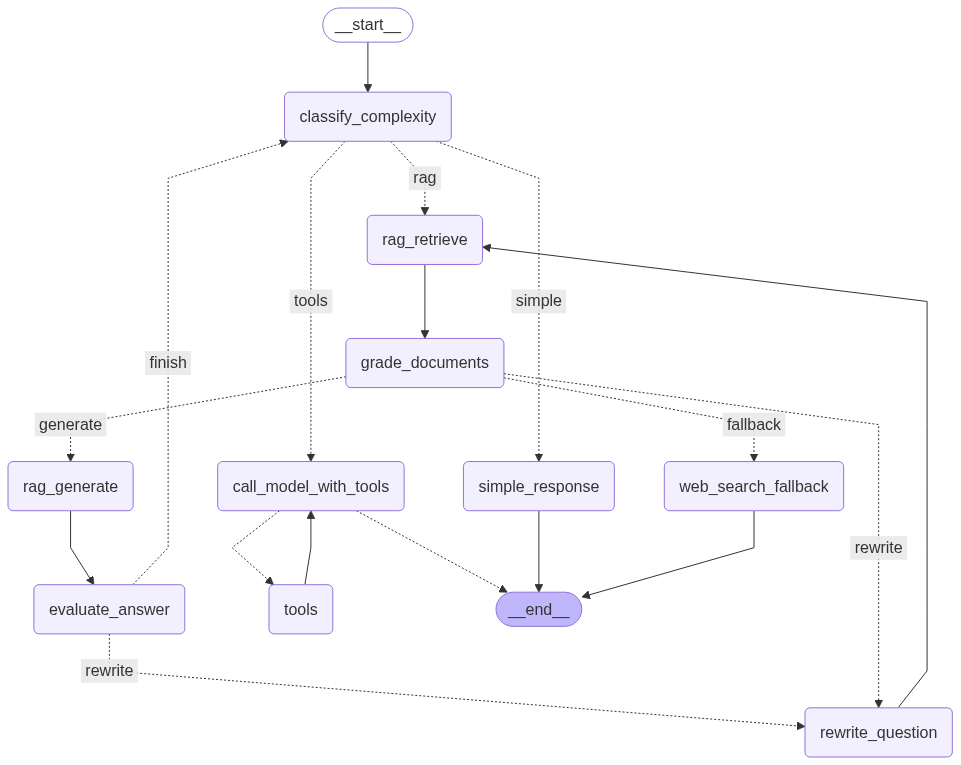

In [58]:
from langgraph.checkpoint.memory import MemorySaver

# MemorySaver para almacenar el estado de la conversación en el hilo actual
within_thread_memory = MemorySaver()

# Define the graph
builder = StateGraph(AdaptiveAgentState)

# Add nodes
builder.add_node("classify_complexity", classify_complexity)
builder.add_node("simple_response", simple_response)

# RAG adaptativo nodes
builder.add_node("rag_retrieve", rag_retrieve)
builder.add_node("grade_documents", grade_documents)
builder.add_node("rag_generate", rag_generate)
builder.add_node("evaluate_answer", evaluate_answer)
builder.add_node("rewrite_question", rewrite_question)
builder.add_node("web_search_fallback", web_search_fallback)

# Tools nodes
builder.add_node("call_model_with_tools", call_model_with_tools)
builder.add_node(
    "tools",
    ToolNode([registrar_cliente, contar_registros, get_current_date, get_program_price])
)

# Add edges
builder.add_edge(START, "classify_complexity")

# Conditional routing from complexity classifier
builder.add_conditional_edges(
    "classify_complexity",
    route_by_complexity,
    {
        "simple": "simple_response",
        "rag": "rag_retrieve", 
        "tools": "call_model_with_tools",
    },
)

# Simple path
builder.add_edge("simple_response", END)

# RAG adaptativo path
builder.add_edge("rag_retrieve", "grade_documents")
builder.add_conditional_edges(
    "grade_documents",
    decide_to_generate_or_rewrite,
    {
        "generate": "rag_generate",
        "rewrite": "rewrite_question",
        "fallback": "web_search_fallback"
    }
)

# Re-write loop
builder.add_edge("rewrite_question", "rag_retrieve")

# Generate and evaluate
builder.add_edge("rag_generate", "evaluate_answer")
builder.add_conditional_edges(
    "evaluate_answer",
    decide_to_finish_or_rewrite,
    {
        #"finish": END,
        "finish": "classify_complexity",
        "rewrite": "rewrite_question"
    }
)

# Fallback path
builder.add_edge("web_search_fallback", END)

# Tools path
builder.add_conditional_edges(
    "call_model_with_tools",
    tools_condition,
    {"tools": "tools", END: END}
)
builder.add_edge("tools", "call_model_with_tools")

# Se compila el grafo con nombre estable para asegurar que se recupere el estado tras reinicios
graph_name = os.getenv("GRAPH_NAME", "chatbot_graph_v1")

graph = builder.compile(
    checkpointer=within_thread_memory,
    name=graph_name,
)
graph

# Pruebas

In [ ]:
#@traceable(name="process_message", metadata={"component": "adaptive_rag_chatbot"})
def process_message(message: str, user_id: str) -> Dict[str, Any]:
    config = {"configurable": {"thread_id": user_id, "user_id": user_id, "checkpoint_ns": graph_name}}
    input_messages = [HumanMessage(content=message)]

    # Inicializar el estado con todos los campos requeridos
    initial_state = {
        "messages": input_messages,
        "complexity_level": None,
        "retrieved_docs": None,
        "question": None,
        "generation": None,
        "answer_evaluation": None,
        "max_retries": 3,
        "retry_count": 0
    }

    result = graph.invoke(initial_state, config)
    ai_message = result["messages"][-1]

    return ai_message.content

In [29]:
print(process_message("que programas hay?", "ernesto"))

---CLASSIFY COMPLEXITY---
Complexity Level: rag
---ROUTE BY COMPLEXITY: rag---
---RAG RETRIEVE---
Recuperando contexto de pregunta: que programas hay?


/tmp/ipykernel_219825/1082237584.py:78: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  documents = retriever.get_relevant_documents(question)


[RAG] Docs recuperados: 10
[0] [Documento: faq][Titulo: Programas y Contenido][Subtitulo: ¿Puedo tomar varios programas consecutivamente?] Absolutamente. Ofrecemos descuentos del 10% para estudiantes que tomen un segundo programa y 15% desde el tercer
    meta: {'has_headers': True, 'document_name': 'faq', 'Header 2': '¿Puedo tomar varios programas consecutivamente?', 'total_chunks_in_file': 26, 'Header 1': 'Programas y Contenido', 'source_path': 'd:\\documentos\\igorov\\datapath\\git\\adaptative-rag-techflow-academy\\data\\faq.md', 'chunk_index': 13, 'source_file': 'faq.md', '_id': '9daf8f32-072f-4b73-bfae-50c5c55829ff', '_collection_name': 'techFlow-academy'}
[1] [Documento: programas][Titulo: Programas][Subtitulo: Lista de programas] Los programas que se tienen son:   - Data Engineer: El programa de Data Engineer está diseñado para formar profesionales capaces de diseñar, constr
    meta: {'source_path': 'd:\\documentos\\igorov\\datapath\\git\\adaptative-rag-techflow-academy\\data\\

In [31]:
print(process_message("cuales son los cursos del programa Data Architect?", "ernesto"))

---CLASSIFY COMPLEXITY---
Complexity Level: rag
---ROUTE BY COMPLEXITY: rag---
---RAG RETRIEVE---
Recuperando contexto de pregunta: cuales son los cursos del programa Data Architect?
[RAG] Docs recuperados: 10
[0] [Documento: cursos][Titulo: Data Architect] El programa de Data Architect forma especialistas en el diseño de arquitecturas de datos empresariales. Los participantes desarrollarán habilidades para crear estrategias de da
    meta: {'Header 1': 'Data Architect', 'source_file': 'cursos.md', 'has_headers': True, 'source_path': 'd:\\documentos\\igorov\\datapath\\git\\adaptative-rag-techflow-academy\\data\\cursos.md', 'total_chunks_in_file': 34, 'chunk_index': 7, 'document_name': 'cursos', '_id': '69030e06-47e9-4128-8642-123d1671a7ce', '_collection_name': 'techFlow-academy'}
[1] [Documento: cursos][Titulo: Data Architect][Subtitulo: Arquitectura de Datos Empresarial] Curso fundamental sobre principios de arquitectura de datos a nivel empresarial. Los estudiantes aprenderán framewo

In [34]:
print(process_message("cuales son los cursos del programa Data Architect cual es el precio de cada uno de ellos?", "ernesto"))


---CLASSIFY COMPLEXITY---
Complexity Level: rag
---ROUTE BY COMPLEXITY: rag---
---RAG RETRIEVE---
Recuperando contexto de pregunta: cuales son los cursos del programa Data Architect cual es el precio de cada uno de ellos?
[RAG] Docs recuperados: 10
[0] [Documento: cursos][Titulo: Data Architect] El programa de Data Architect forma especialistas en el diseño de arquitecturas de datos empresariales. Los participantes desarrollarán habilidades para crear estrategias de da
    meta: {'Header 1': 'Data Architect', 'source_file': 'cursos.md', 'has_headers': True, 'source_path': 'd:\\documentos\\igorov\\datapath\\git\\adaptative-rag-techflow-academy\\data\\cursos.md', 'total_chunks_in_file': 34, 'chunk_index': 7, 'document_name': 'cursos', '_id': '69030e06-47e9-4128-8642-123d1671a7ce', '_collection_name': 'techFlow-academy'}
[1] [Documento: cursos][Titulo: Data Architect][Subtitulo: Arquitectura de Datos Empresarial] Curso fundamental sobre principios de arquitectura de datos a nivel empresar

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [35]:
# Obtener el código Mermaid del grafo
mermaid_code = graph.get_graph().draw_mermaid()
print("Código Mermaid del grafo:")
print(mermaid_code)


Código Mermaid del grafo:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	classify_complexity(classify_complexity)
	simple_response(simple_response)
	rag_retrieve(rag_retrieve)
	grade_documents(grade_documents)
	rag_generate(rag_generate)
	evaluate_answer(evaluate_answer)
	rewrite_question(rewrite_question)
	web_search_fallback(web_search_fallback)
	call_model_with_tools(call_model_with_tools)
	tools(tools)
	__end__([<p>__end__</p>]):::last
	__start__ --> classify_complexity;
	call_model_with_tools -.-> __end__;
	call_model_with_tools -.-> tools;
	classify_complexity -. &nbsp;tools&nbsp; .-> call_model_with_tools;
	classify_complexity -. &nbsp;rag&nbsp; .-> rag_retrieve;
	classify_complexity -. &nbsp;simple&nbsp; .-> simple_response;
	evaluate_answer -. &nbsp;finish&nbsp; .-> classify_complexity;
	evaluate_answer -. &nbsp;rewrite&nbsp; .-> rewrite_question;
	grade_documents -. &nbsp;generate&nbsp; .-> rag_generate;
	grade_documents -. &n

# RAG como Tool

In [83]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_techflow_academy_info", # nombre de la tool
    "Busca y devuelve información sobre Programas, cursos, docentes, empresas aliadas, preguntas frecuentes, testimonio de graduados, matriculas y reglamentos sobre el instituto Techflow Academy", # descripcion de la tool
)

tools = [
    retriever_tool,
    registrar_cliente,
    contar_registros,
    get_current_date,
    get_program_price
]

In [84]:
model = llm.bind_tools(tools)

```python
class AdaptiveAgentState(TypedDict):
    """
    Estado personalizado que incluye mensajes y metadatos del RAG adaptativo
    """
    messages: Annotated[List[BaseMessage], add_messages]
    complexity_level: Optional[str]
    retrieved_docs: Optional[List[Any]]
    question: Optional[str]  # Pregunta actual (original o reformulada)
    generation: Optional[str]  # Respuesta generada
    answer_evaluation: Optional[str]  # Resultado de evaluación de la respuesta ('yes'/'no')
    max_retries: Optional[int]  # Máximo número de reintentos
    retry_count: Optional[int]  # Contador de reintentos
```

In [85]:
# Nuevo nodo inicial
def agent(state: AdaptiveAgentState):
    """
    Invoca al modelo del agente para generar una respuesta basada en el estado actual. Dada
    la pregunta, decidirá si recuperar usando la herramienta retriever o simplemente terminar.

    Args:
        state (messages): El estado actual

    Returns:
        dict: El estado actual con la respuesta del agente agregada a los mensajes
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    messages.append(HumanMessage(content="Responde la pregunta del usuario basado en la cadena de mensajes y la peticion que te hizo"))
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

## Nuevo grafo

In [86]:
from typing import Literal
from langchain_core.messages import AIMessage, ToolMessage

def validar_rag(state: "AdaptiveAgentState") -> Literal["generate", "agent"]:
    """
    Valida si se usó la tool del retriever (RAG) para decidir el siguiente nodo.
    
    Si se ejecutó la tool 'retrieve_techflow_academy_info', va al nodo 'generate'.
    Si se ejecutaron otras tools, regresa al nodo 'agent'.
    """
    print("---VALIDAR RAG---")
    
    messages = state.get("messages", [])
    
    # Buscar el último mensaje AI que tenga tool_calls
    for message in reversed(messages):
        if isinstance(message, AIMessage) and hasattr(message, 'tool_calls') and message.tool_calls:
            # Verificar si alguna de las tool_calls es la del retriever
            for tool_call in message.tool_calls:
                tool_name = tool_call.get("name", "")
                print(f"Tool ejecutada: {tool_name}")
                
                if tool_name == "retrieve_techflow_academy_info":
                    print("Se detectó tool del retriever RAG -> ir a 'generate'")
                    return "generate"
            
            # Si llegamos aquí, se ejecutaron otras tools pero no el retriever
            print("Se ejecutaron otras tools (no RAG) -> regresar a 'agent'")
            return "agent"
    
    # Si no se encontraron tool_calls, por defecto regresar al agent
    print("No se encontraron tool_calls -> regresar a 'agent'")
    return "agent"

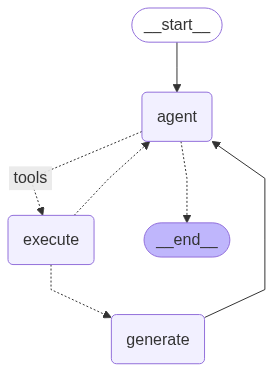

In [87]:
def generate(state: AdaptiveAgentState):
    """
    Genera una respuesta basada en el contexto RAG recuperado
    """
    print("---GENERATE---")
    
    messages = state.get("messages", [])
    
    # Buscar el último ToolMessage que contenga el contexto del RAG
    rag_context = ""
    for message in reversed(messages):
        if hasattr(message, 'content') and isinstance(message.content, str):
            # Los resultados del retriever vienen en ToolMessage
            if "Documento:" in message.content or any(keyword in message.content.lower() for keyword in ["techflow", "programa", "curso"]):
                rag_context = message.content
                print(f"Contexto RAG encontrado: {rag_context[:200]}...")
                break
    
    # Si no encontramos contexto específico, usar el último mensaje de tool
    if not rag_context:
        for message in reversed(messages):
            if hasattr(message, 'content') and len(str(message.content)) > 50:
                rag_context = str(message.content)
                print(f"Usando último contenido como contexto: {rag_context[:200]}...")
                break
    
    # Crear prompt para generar respuesta basada en el contexto RAG
    system_prompt = f"""Eres un asistente especializado de TechFlow Academy.

Basándote en la siguiente información recuperada, genera una respuesta clara y útil para el usuario.

Contexto RAG:
{rag_context}

Instrucciones:
- Responde de manera clara y estructurada
- Usa solo la información proporcionada en el contexto
- Si la información es limitada, indícalo y sugiere formas de obtener más detalles
- Mantén un tono profesional y amigable"""

    # Obtener la pregunta original del usuario
    user_question = ""
    for message in messages:
        if isinstance(message, HumanMessage):
            user_question = message.content
    
    # Crear el mensaje para el modelo
    messages_for_model = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_question)
    ]
    
    response = llm.invoke(messages_for_model)
    return {"messages": [response]}

from langgraph.checkpoint.memory import MemorySaver

# MemorySaver para almacenar el estado de la conversación en el hilo actual
within_thread_memory = MemorySaver()

# Define the graph
builder = StateGraph(AdaptiveAgentState)

# Add nodes
builder.add_node("agent", agent)
execute = ToolNode(tools)
builder.add_node("execute", execute)  # retrieval
builder.add_node("generate", generate)  # genera respuestas basadas en RAG

# Flujo: START -> agent -> execute -> (generate o agent)
builder.add_edge(START, "agent")

builder.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "execute",
        END: END,
    },
)

builder.add_conditional_edges(
    "execute",
    validar_rag,
    {
        "generate": "generate",
        "agent": "agent"
    }
)

# El nodo generate regresa al agent para continuar la conversación
builder.add_edge("generate", "agent")

graph_name = os.getenv("GRAPH_NAME", "chatbot_graph_v1")

graph = builder.compile(
    checkpointer=within_thread_memory,
    name=graph_name,
)
graph

In [88]:
# Prueba del nuevo grafo
print("=== PROBANDO EL GRAFO CORREGIDO ===")

# Función para procesar mensajes (similar a la anterior)
@traceable(name="process_message", metadata={"component": "adaptive_rag_chatbot"})
def process_message_v2(message: str, user_id: str) -> str:
    config = {"configurable": {"thread_id": user_id, "user_id": user_id, "checkpoint_ns": graph_name}}
    input_messages = [HumanMessage(content=message)]

    # Inicializar el estado
    initial_state = {
        "messages": input_messages,
    }

    result = graph.invoke(initial_state, config)
    ai_message = result["messages"][-1]

    return ai_message.content


=== PROBANDO EL GRAFO CORREGIDO ===


In [62]:
# Probar con una pregunta que debería usar RAG
print("\\n1. Probando pregunta sobre programas (debería usar RAG):")
response1 = process_message_v2("que cursos hay en el programa Data Architect", "test_user_1")
print(f"Respuesta: {response1}")

\n1. Probando pregunta sobre programas (debería usar RAG):
---CALL AGENT---
---VALIDAR RAG---
Tool ejecutada: retrieve_techflow_academy_info
Se detectó tool del retriever RAG -> ir a 'generate'
---GENERATE---
Contexto RAG encontrado: [Documento: cursos][Titulo: Data Architect] El programa de Data Architect forma especialistas en el diseño de arquitecturas de datos empresariales. Los participantes desarrollarán habilidades para cre...
---CALL AGENT---
Respuesta: El programa de Data Architect incluye los siguientes cursos:

1. **Arquitectura de Datos Empresarial**: Curso fundamental sobre principios de arquitectura de datos a nivel empresarial, incluyendo frameworks como TOGAF y Zachman, diseño de data lakes y data warehouses, así como estrategias de modernización y migración de datos.

2. **Data Mesh y Arquitecturas Modernas**: Curso especializado en arquitecturas emergentes como Data Mesh y Data Fabric, explorando principios de descentralización, productos de datos y arquitecturas orie

In [89]:
# Probar con una pregunta que debería usar RAG
print("\\n1. Probando pregunta sobre programas (debería usar RAG):")
response1 = process_message_v2("cual es el costo del curso Arquitectura de Datos Empresarial?", "test_user_1")
print(f"Respuesta: {response1}")

\n1. Probando pregunta sobre programas (debería usar RAG):
---CALL AGENT---
Buscando precio del programa: Arquitectura de Datos Empresarial
[get_program_price] Error consultando precio: relation "public.programas" does not exist
LINE 3:         FROM public.programas
                     ^
---VALIDAR RAG---
Tool ejecutada: get_program_price
Se ejecutaron otras tools (no RAG) -> regresar a 'agent'
---CALL AGENT---
Respuesta: No se encontró información sobre el costo del curso "Arquitectura de Datos Empresarial". Puede que el curso no esté disponible actualmente o que no se haya establecido un precio. Te recomendaría consultar directamente con Techflow Academy para obtener más detalles.


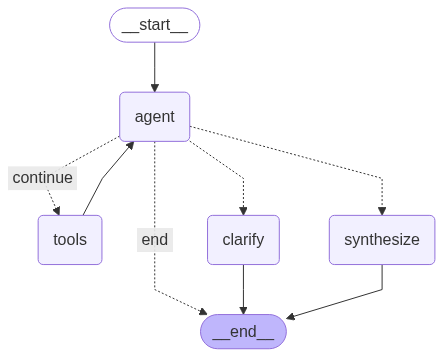

In [38]:
from typing import TypedDict, Annotated, Literal, List, Dict, Any
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
import operator

# ===== ESTADOS =====

class AgentState(TypedDict):
    """Estado del agente principal"""
    messages: Annotated[List[BaseMessage], operator.add]
    query: str
    rag_context: str
    tool_results: Dict[str, Any]
    iteration_count: int
    max_iterations: int
    next_action: str

class RAGState(TypedDict):
    """Estado del subgrafo RAG"""
    query: str
    original_query: str
    retrieved_docs: List[Dict]
    relevance_scores: List[float]
    reformulated_queries: List[str]
    final_context: str
    relevance_threshold: float
    iteration_count: int

# ===== NODOS DEL GRAFO PRINCIPAL =====

def agent_node(state: AgentState) -> AgentState:
    """
    Nodo principal del agente - Analiza el estado y decide próxima acción
    
    Responsabilidades:
    - Evaluar la consulta original y contexto acumulado
    - Determinar si necesita más información (RAG, tools)
    - Decidir si puede sintetizar respuesta final
    - Prevenir bucles infinitos
    """
    # TODO: Implementar lógica de decisión
    # - Analizar mensajes y contexto actual
    # - Determinar next_action basado en información disponible
    # - Incrementar iteration_count
    # - Evaluar si se alcanzó max_iterations
    
    return {
        "next_action": "use_rag",  # Placeholder
        "iteration_count": state.get("iteration_count", 0) + 1
    }

def synthesize_node(state: AgentState) -> AgentState:
    """
    Sintetiza la respuesta final combinando RAG y tool results
    
    Responsabilidades:
    - Combinar información de RAG con resultados de herramientas
    - Generar respuesta coherente y completa
    - Formatear respuesta final para el usuario
    """
    # TODO: Implementar síntesis de respuesta
    # - Combinar rag_context con tool_results
    # - Generar respuesta final usando LLM
    # - Agregar mensaje final a messages
    
    return {
        "messages": [AIMessage(content="Respuesta sintetizada")],  # Placeholder
        "next_action": "end"
    }

def clarification_node(state: AgentState) -> AgentState:
    """
    Solicita clarificación cuando la consulta es ambigua
    
    Responsabilidades:
    - Identificar qué información específica falta
    - Generar preguntas clarificadoras
    - Preparar el estado para recibir input adicional del usuario
    """
    # TODO: Implementar lógica de clarificación
    # - Analizar por qué la consulta es ambigua
    # - Generar preguntas específicas
    # - Crear mensaje de clarificación
    
    return {
        "messages": [AIMessage(content="¿Podrías clarificar...?")],  # Placeholder
        "next_action": "end"
    }

# ===== FUNCIONES DE ROUTING =====

def should_continue(state: AgentState) -> Literal["continue", "synthesize", "clarify", "end"]:
    """
    Determina el siguiente paso basado en el estado actual
    
    Lógica de decisión:
    - "continue": Si necesita más información (RAG o tools)
    - "synthesize": Si tiene suficiente info para responder
    - "clarify": Si la consulta es ambigua
    - "end": Si alcanzó límite de iteraciones o hay error
    """
    # TODO: Implementar lógica de routing
    # - Evaluar next_action del estado
    # - Verificar iteration_count vs max_iterations
    # - Determinar si hay suficiente información
    
    next_action = state.get("next_action", "")
    
    if next_action in ["use_rag", "use_tool"]:
        return "continue"
    elif next_action == "synthesize":
        return "synthesize"
    elif next_action == "clarify":
        return "clarify"
    else:
        return "end"

# ===== NODOS DEL SUBGRAFO RAG =====

def initial_retrieval_node(state: RAGState) -> RAGState:
    """
    Primer retrieval de documentos relevantes
    
    Responsabilidades:
    - Convertir query a embeddings
    - Buscar en vector store
    - Recuperar top-k documentos candidatos
    """
    # TODO: Implementar retrieval inicial
    # - Generar embeddings de la query
    # - Realizar búsqueda semántica
    # - Recuperar documentos candidatos
    
    return {
        "retrieved_docs": [],  # Placeholder
        "relevance_scores": []
    }

def relevance_validation_node(state: RAGState) -> RAGState:
    """
    Valida la relevancia de los documentos recuperados
    
    Responsabilidades:
    - Evaluar similarity scores
    - Aplicar modelo de scoring de relevancia
    - Determinar si la calidad es suficiente
    """
    # TODO: Implementar validación de relevancia
    # - Calcular scores de relevancia
    # - Comparar con threshold
    # - Determinar si necesita reformulación
    
    return {
        "relevance_scores": [0.7, 0.6, 0.5]  # Placeholder
    }

def query_reformulation_node(state: RAGState) -> RAGState:
    """
    Reformula la query para mejorar retrieval
    
    Responsabilidades:
    - Analizar por qué falló la búsqueda inicial
    - Generar queries alternativas
    - Aplicar técnicas como HyDE, expansión de términos
    """
    # TODO: Implementar reformulación de query
    # - Analizar términos de la query original
    # - Generar sinónimos y términos relacionados
    # - Crear queries alternativas
    
    return {
        "reformulated_queries": ["query reformulada"],  # Placeholder
        "query": "nueva query reformulada"
    }

def enhanced_retrieval_node(state: RAGState) -> RAGState:
    """
    Segundo retrieval con query mejorada
    
    Responsabilidades:
    - Ejecutar búsqueda con query reformulada
    - Combinar con resultados anteriores si es relevante
    - Re-evaluar relevancia
    """
    # TODO: Implementar retrieval mejorado
    # - Usar query reformulada
    # - Realizar nueva búsqueda
    # - Combinar/filtrar resultados
    
    return {
        "retrieved_docs": [],  # Placeholder - docs mejorados
        "relevance_scores": []
    }

def context_ranking_node(state: RAGState) -> RAGState:
    """
    Rankea y selecciona los mejores contextos
    
    Responsabilidades:
    - Ordenar documentos por relevancia
    - Seleccionar top contextos
    - Generar contexto final estructurado
    """
    # TODO: Implementar ranking de contexto
    # - Ordenar por relevance_scores
    # - Seleccionar mejores documentos
    # - Estructurar contexto final
    
    return {
        "final_context": "Contexto final generado"  # Placeholder
    }

def fallback_response_node(state: RAGState) -> RAGState:
    """
    Maneja casos donde no se encuentra información relevante
    
    Responsabilidades:
    - Generar respuesta cuando RAG falla
    - Sugerir reformulación de la pregunta
    - Proporcionar respuesta alternativa
    """
    # TODO: Implementar respuesta fallback
    # - Generar mensaje apropiado para falta de info
    # - Sugerir cómo reformular la pregunta
    
    return {
        "final_context": "No se encontró información relevante"  # Placeholder
    }

# ===== FUNCIONES DE ROUTING DEL SUBGRAFO RAG =====

def check_relevance_quality(state: RAGState) -> Literal["high_relevance", "low_relevance"]:
    """Evalúa si la relevancia de los documentos es suficiente"""
    # TODO: Implementar evaluación de relevancia
    # - Comparar scores con threshold
    # - Evaluar calidad promedio
    
    avg_relevance = sum(state.get("relevance_scores", [0])) / max(len(state.get("relevance_scores", [1])), 1)
    threshold = state.get("relevance_threshold", 0.6)
    
    return "high_relevance" if avg_relevance >= threshold else "low_relevance"

def check_enhanced_relevance(state: RAGState) -> Literal["better_relevance", "still_low", "max_iterations"]:
    """Evalúa si el retrieval mejorado tuvo éxito"""
    # TODO: Implementar evaluación de retrieval mejorado
    # - Comparar nuevos scores con anteriores
    # - Verificar límite de iteraciones
    
    return "better_relevance"  # Placeholder

# ===== CREACIÓN DEL SUBGRAFO RAG =====

def create_rag_subgraph() -> StateGraph:
    """Crea el subgrafo complejo de RAG"""
    rag_workflow = StateGraph(RAGState)
    
    # Agregar nodos
    rag_workflow.add_node("initial_retrieval", initial_retrieval_node)
    rag_workflow.add_node("relevance_check", relevance_validation_node)
    rag_workflow.add_node("query_reformulator", query_reformulation_node)
    rag_workflow.add_node("enhanced_retrieval", enhanced_retrieval_node)
    rag_workflow.add_node("context_ranker", context_ranking_node)
    rag_workflow.add_node("fallback", fallback_response_node)
    
    # Configurar flujo
    rag_workflow.set_entry_point("initial_retrieval")
    
    # Aristas
    rag_workflow.add_edge("initial_retrieval", "relevance_check")
    
    # Aristas condicionales
    rag_workflow.add_conditional_edges(
        "relevance_check",
        check_relevance_quality,
        {
            "high_relevance": "context_ranker",
            "low_relevance": "query_reformulator"
        }
    )
    
    rag_workflow.add_edge("query_reformulator", "enhanced_retrieval")
    
    rag_workflow.add_conditional_edges(
        "enhanced_retrieval",
        check_enhanced_relevance,
        {
            "better_relevance": "context_ranker",
            "still_low": "fallback",
            "max_iterations": "fallback"
        }
    )
    
    # Terminaciones
    rag_workflow.add_edge("context_ranker", END)
    rag_workflow.add_edge("fallback", END)
    
    return rag_workflow

# ===== HERRAMIENTA RAG COMPILADA =====

def create_rag_tool():
    """Convierte el subgrafo RAG en una herramienta"""
    rag_subgraph = create_rag_subgraph().compile()
    
    @tool
    def advanced_rag_search(query: str) -> str:
        """
        Búsqueda avanzada en base de conocimientos con validación y refinamiento.
        
        Args:
            query: Consulta de búsqueda en lenguaje natural
            
        Returns:
            Contexto relevante encontrado en la base de conocimientos
        """
        initial_state = {
            "query": query,
            "original_query": query,
            "retrieved_docs": [],
            "relevance_scores": [],
            "reformulated_queries": [],
            "final_context": "",
            "relevance_threshold": 0.6,
            "iteration_count": 0
        }
        
        result = rag_subgraph.invoke(initial_state)
        return result["final_context"]
    
    return advanced_rag_search

# ===== HERRAMIENTAS ADICIONALES =====

@tool
def calculator(expression: str) -> str:
    """Evalúa expresiones matemáticas simples."""
    # TODO: Implementar calculadora segura
    return f"Resultado de {expression}"

@tool
def web_search(query: str) -> str:
    """Busca información actualizada en la web."""
    # TODO: Implementar búsqueda web
    return f"Resultados web para: {query}"

@tool
def calendar_search(date_query: str) -> str:
    """Consulta eventos en el calendario."""
    # TODO: Implementar consulta de calendario
    return f"Eventos para: {date_query}"

# ===== GRAFO PRINCIPAL =====



def create_main_agent() -> StateGraph:
    """Crea el agente principal con todas las herramientas"""
    
    # Herramientas disponibles
    tools = [
        create_rag_tool(),
        calculator,
        web_search,
        calendar_search
    ]
    
    # Crear workflow principal
    workflow = StateGraph(AgentState)
    
    # Agregar nodos
    workflow.add_node("agent", agent_node)
    workflow.add_node("tools", ToolNode(tools))
    workflow.add_node("synthesize", synthesize_node)
    workflow.add_node("clarify", clarification_node)
    
    # Configurar flujo
    workflow.set_entry_point("agent")
    
    # Aristas condicionales desde el agente
    workflow.add_conditional_edges(
        "agent",
        should_continue,
        {
            "continue": "tools",
            "synthesize": "synthesize",
            "clarify": "clarify",
            "end": END
        }
    )
    
    # Las herramientas regresan al agente
    workflow.add_edge("tools", "agent")
    
    # Terminaciones
    workflow.add_edge("synthesize", END)
    workflow.add_edge("clarify", END)
    
    return workflow

# ===== FUNCIÓN PRINCIPAL =====

def create_agent():
    """Crea y compila el agente completo"""
    workflow = create_main_agent()
    return workflow.compile()

# ===== USO =====

grafo = create_agent()
grafo